# Libraries

In [11]:
#General
import csv
import pandas as pd
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
import numpy as np
import time
import matplotlib.pyplot as plt

#Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import HashingVectorizer

#Spark
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
# Text processing
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover
# Prediction model parameters
from pyspark.ml.classification import LogisticRegression as LogisticRegressionSpark
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
# Prediction model evaluation
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# PYTHON ALGORITHM

### Function Definition

In [2]:
#loading the data and limit
#Limit is the limit size of the data
def load_data(path, limit):
    
    #LOAD FILE
    data = pd.read_csv(str(path))
    #Limit the data
    data = data.head(limit)
    
    
    return data


#Stop words and lowercase
#This function is used in clean_data
def clean_txt(txt, stopwords_nltk):
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf_8').get_text()
    txt = txt.lower()
    
    ### remove french stop words
    querywords = txt.split()
    txt  = [word for word in querywords if word not in stopwords_nltk] 
    
    return(txt)

#Cleaning the data 
#Remove \n lowercase and stopwords (using clean_txt)
def clean_data(data, stopwords_nltk):
    
    #REPLACE '\n' by ' '
    data['comment_text'] = data['comment_text'].replace(r'\n',' ', regex=True)
    
    #Lowercase and stopwords
    data['comment_text'] = data['comment_text'].apply(lambda x: clean_txt(x, stopwords_nltk))
    
    return data

#Function used to tokenize
def identity_tokenizer(text):
        return text

#Train/Test division and tokenize 
#Threshold is the Test/Train division threshold (75/25)
#If hashing is 'yes' -> Vectorizer is hashing, else it is Tfidf
#If hashing is 'yes' -> num_features is the n_hash of hashing
def train_test_tokenizer(data, threshold, hashing, num_features):
    
    #List of labels
    labels = [col for col in list(data.columns) if col not in ["id", "comment_text"]]
    
    #Train/Test division
    data['rand'] = np.random.randint(1, 100, data.shape[0])
    data_test = data.loc[data['rand']>75][[col for col in data.columns 
                                                               if col not in ['rand']]].reset_index(drop=True)
    data_train = data.loc[data['rand']<=75][[col for col in data.columns 
                                                                 if col not in ['rand']]].reset_index(drop=True)

    #Transform the sentences - TF IDF

    if hashing == 'yes':
        vectorizer = HashingVectorizer(tokenizer=identity_tokenizer, lowercase = False, n_features=num_features)
    else :
        vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase = False)
    response = vectorizer.fit_transform(data_train['comment_text'].values)
    data_transform_train = pd.DataFrame(response.todense()) #Put it in a dataframe
    data_transform_train = pd.concat([data_transform_train, data_train[labels]], axis = 1) #Join features and labels
    response = vectorizer.transform(data_test['comment_text'].values)
    data_transform_test = pd.DataFrame(response.todense()) #Put it in a dataframe
    data_transform_test = pd.concat([data_transform_test, data_test[labels]], axis = 1) #Join features and labels

    X_train = data_transform_train[[col for col in data_transform_train.columns if col not in labels]]
    Y_train = data_transform_train[[col for col in labels]]

    X_test = data_transform_test[[col for col in data_transform_test.columns if col not in labels]]
    Y_test = data_transform_test[[col for col in labels]]
    
    return X_train, Y_train, X_test, Y_test

#For each labels, it fit and predict and show accuracy on test set
def fit_score(X_train, Y_train, X_test, Y_test, reg, n_process):
    
    labels = [col for col in Y_train.columns]
        
    for col in labels:
        print(col)
        lr = LogisticRegression(C = reg, solver='lbfgs', n_jobs = n_process)
        print("...fitting")
        lrModel = lr.fit(X_train.values, Y_train[str(col)].values)
        print("...predicting")
        res = lrModel.predict(X_test.values)
        print("...accuracy result")
        acc = accuracy_score(Y_test[str(col)], res)
        print("%.3f" % acc)

    print('\n END \n')

#Final function which put together all functions 
#path : Path of the data ; limit : limit for the data ; threshold : train/test division 
#hashing : yes for hashing else tfidf ; num_features : n_hash of hashing ; 
#reg : logistic regression parameter
def prediction_time(path, limit, threshold, hashing, num_features, reg, stopwords_nltk, n_process):

    #RECORDING TOTAL TIME
    total_time = time.time()

    #LOAD DATA
    data = load_data(path, limit)
    print('LOAD DATA ----- OK \n')

    #SHOW DATA
    print("DATA VISUALISATION")
    print(data.head(2))

    #CLEAN DATA
    clean_time = time.time()
    data = clean_data(data, stopwords_nltk)
    clean_time = time.time() - clean_time

    #TOKENIZE + TRAIN/TEST DIVISION
    tfidf_time = time.time()
    X_train, Y_train, X_test, Y_test = train_test_tokenizer(data, threshold, hashing, num_features)
    tfidf_time = time.time() - tfidf_time 
    print('CLEAN + TF-IDF ----- OK')

    #Pediction and accuracy 
    prediction_time = time.time()
    fit_score(X_train, Y_train, X_test, Y_test, reg, n_process)

    #PRINT TIME
    print('Total time : ', "{0:.2f}".format((time.time()-total_time)), 'sec')
    print('Clean time : ', "{0:.2f}".format(clean_time), 'sec')
    print('TF-IDF time : ', "{0:.2f}".format(tfidf_time), 'sec')
    print('Prediction time : ', "{0:.2f}".format((time.time()-prediction_time)), 'sec')

### Running the algorithm

> prediction_time function takes parameters of the data and parameters about cleaning, vectorization and
> prediction as input and it returns different running times (Total time, cleaning time, vectorization time 
> and learning time) and accuracies as output

> Input :
>> limit : Limit size of the data (take limit first rows)

>> reg : Logistic regression parameter

>> hashing : 'yes' for hashing vectorization, else for TF-IDF

>> num_features : n_hash, limit number of features

>> path : Path of the data

>> threshold : Threshold for Train/Test division used for learning part (75/25)

>> stopwords_nltk : Stop Words function used for cleaning

>> n_process : n_jobs parameter for Logistic Regression


In [3]:
# CHOOSE PARAMETERS
limit = 30000 #limit file
reg = 1.0 #regularization for logistic regression
hashing = 'yes' #yes if hashing, else tf-idf
num_features = 1000
path = '/Users/Carmemac/Desktop/all/train.csv'
threshold = 75 #Div Train Test
stopwords_nltk = stopwords.words('english')
n_process = None

#PREDICTION
prediction_time(path, limit, threshold, hashing, num_features, reg, stopwords_nltk, n_process)

LOAD DATA ----- OK 

DATA VISUALISATION
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  


/Applications/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:146: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


CLEAN + TF-IDF ----- OK
toxic
...fitting
...predicting
...accuracy result
0.926
severe_toxic
...fitting
...predicting
...accuracy result
0.990
obscene
...fitting
...predicting
...accuracy result
0.965
threat
...fitting
...predicting
...accuracy result
0.997
insult
...fitting
...predicting
...accuracy result
0.960
identity_hate
...fitting
...predicting
...accuracy result
0.992

 END 

Total time :  22.78 sec
Clean time :  6.96 sec
TF-IDF time :  1.30 sec
Prediction time :  13.57 sec


# SPARK ALGORITHM

### Environment Definition

In [4]:
spark = SparkSession.builder.getOrCreate()
sc = (SparkSession.builder
                  .appName('PLP Project')
                  .enableHiveSupport()
                  .config("spark.executor.memory", "4G")
                  .config("spark.driver.memory","18G")
                  .config("spark.executor.cores","7")
                  .config("spark.python.worker.memory","4G")
                  .config("spark.driver.maxResultSize","0")
                  .config("spark.sql.crossJoin.enabled", "true")
                  .config("spark.serializer","org.apache.spark.serializer.KryoSerializer")
                  .config("spark.default.parallelism","2")
                  .config('spark.executor.instances', '8')
                  .getOrCreate())
sc.version

'2.4.0'

### Function Definition

In [5]:
#Load and convert the data into Spark DataFrame
def convert_to_spark_df(path):
    """   
    Input:
    file : csv file to read
        
    Output:
    df : a spark DataFrame containing the parsed csv data.
    """
    
    df = pd.read_csv(path)
    df.fillna("", inplace=True)
    df = sc.createDataFrame(df)
    return(df)

#Return running time for each part (cleaning, vectorization, learning) and accuracies
def get_time_and_error(data, nb_samples, num_features):
    print("Number of samples", nb_samples)
    print("Number of features", num_features)
    
    # Getting data
    data_reduced = data.limit(nb_samples)
    train, test = data_reduced.randomSplit([0.75, 0.25], seed=12345)
    columns = [col for col in train.columns if col not in ["id", "comment_text"]]
    print("Number of comments in the training set:", train.count())
    print("Number of comments in the test set:", test.count())
    
    # Tokenization
    time_init_1 = time.time()
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
    train_tokens = tokenizer.transform(train)
    test_tokens = tokenizer.transform(test)
    time_fin_1 = time.time()
    print('Tokenization time in seconds :', (time_fin_1 - time_init_1))

    # Cleaning: removing stopwords
    time_init_2 = time.time()
    remover = StopWordsRemover(inputCol="words", outputCol="words_filtered")
    train_tokens_clean = remover.transform(train_tokens)
    test_tokens_clean = remover.transform(test_tokens)
    time_fin_2 = time.time()
    print('Cleaning time in seconds :', (time_fin_2 - time_init_2))

    # Hashing TF
    time_init_3 = time.time()
    hashingTF = HashingTF(inputCol="words_filtered", outputCol="feats", numFeatures = num_features)
    train_tf = hashingTF.transform(train_tokens_clean)
    test_tf = hashingTF.transform(test_tokens_clean)
    time_fin_3 = time.time()
    print('HashingTF time in seconds :', (time_fin_3 - time_init_3))

    # IDF
    time_init_4 = time.time()
    idf = IDF(inputCol="feats", outputCol="features")
    idfModel = idf.fit(train_tf) 
    train_tfidf = idfModel.transform(train_tf)
    test_tfidf = idfModel.transform(test_tf)
    time_fin_4 = time.time()
    print('IDF time in seconds :', (time_fin_4 - time_init_4))
    
    # Prediction: logistic regression
    time_init_5 = time.time()
    errors = []
    for col in columns:
        print(col)
        lr = LogisticRegressionSpark(featuresCol="features", labelCol=col, regParam=0.1)    
        print("...fitting")
        lrModel = lr.fit(train_tfidf)
        print("...predicting")
        res = lrModel.transform(test_tfidf)
        print("...appending result")
        
        evaluator = MulticlassClassificationEvaluator(
        labelCol=col, predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(res)
        print("Accuracy =", accuracy)
        print("Test Error = %g" % (1.0 - accuracy))
        errors.append((1.0 - accuracy))
    time_fin_5 = time.time()
    print('Learning time in seconds :', (time_fin_5 - time_init_5))
    
    # Saving time values & test error
    cleaning_time = (time_fin_2 - time_init_2)
    vectorization_time = (time_fin_1 - time_init_1) + (time_fin_3 - time_init_3) + (time_fin_4 - time_init_4)
    learning_time = (time_fin_5 - time_init_5) 
    
    return cleaning_time, vectorization_time, learning_time, errors

### Running the algorithm

> convert_to_spark_df function takes path of the data as input and returns a Spark DataFrame as output

> Input :
>> path : Path of the data

> get_time_and_error function takes the data and parameters about cleaning, vectorization 
> as input and it returns different running times (Cleaning time, vectorization time 
> and learning time) and accuracies as output

> Input :
>> data : Data we work on - Spark DataFrame

>> nb_samples : Size of the data to limit

>> num_features : n_hash, limit number of features

### Parameters

In [6]:
#Choose parameters
nb_samples = 30000
num_features = 1000
path = '/Users/Carmemac/Desktop/all/train.csv'

### Load the data

In [7]:
data = convert_to_spark_df(path)

### Prediction

In [8]:
get_time_and_error(data, nb_samples, num_features)

Number of samples 30000
Number of features 1000
Number of comments in the training set: 22315
Number of comments in the test set: 7685
Tokenization time in seconds : 0.1081230640411377
Cleaning time in seconds : 0.5108001232147217
HashingTF time in seconds : 0.1218407154083252
IDF time in seconds : 4.634544849395752
toxic
...fitting
...predicting
...appending result
Accuracy = 0.9008458035133377
Test Error = 0.0991542
severe_toxic
...fitting
...predicting
...appending result
Accuracy = 0.9903708523096942
Test Error = 0.00962915
obscene
...fitting
...predicting
...appending result
Accuracy = 0.9465191932335719
Test Error = 0.0534808
threat
...fitting
...predicting
...appending result
Accuracy = 0.997007156798959
Test Error = 0.00299284
insult
...fitting
...predicting
...appending result
Accuracy = 0.9513337670787247
Test Error = 0.0486662
identity_hate
...fitting
...predicting
...appending result
Accuracy = 0.991021470396877
Test Error = 0.00897853
Learning time in seconds : 51.72393870

(0.5108001232147217,
 4.864508628845215,
 51.72393870353699,
 [0.09915419648666235,
  0.009629147690305762,
  0.05348080676642808,
  0.0029928432010409844,
  0.048666232921275254,
  0.008978529603122953])

# PLOTS 

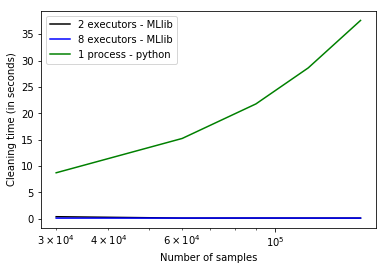

In [12]:
# Cleaning time
sample_size = [30000, 60000, 90000, 120000, 160000]
spark_2instances = [0.40718579292297363,0.1423196792602539,0.14638495445251465,0.14662694931030273,0.1470320224761963]
spark_8instances = [0.14103293418884277,0.14890074729919434,0.1599559783935547,0.14829301834106445,0.142625093460083]
python_1 = [8.74,15.25, 21.80,28.63,37.63]

plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Cleaning time (in seconds)')
plt.plot(sample_size, spark_2instances, 'k')
plt.plot(sample_size, spark_8instances, 'b')
plt.plot(sample_size, python_1, 'g')
plt.legend(['2 executors - MLlib', '8 executors - MLlib', '1 process - python'])
plt.savefig('clean')
plt.show()

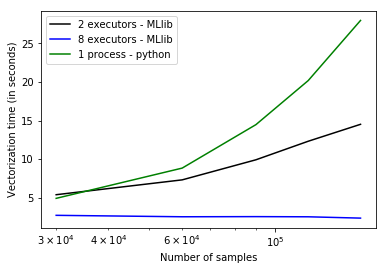

In [13]:
# Vectorization time
spark_2instances = [5.391401290893555,7.314995050430298,9.915636777877808,12.319015502929688,14.512500524520874]
spark_8instances = [2.720379114151001,2.533787965774536,2.5524580478668213,2.5305747985839844,2.358982801437378]
python_1 = [4.92,8.84, 14.47,20.18,27.97]

plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Vectorization time (in seconds)')
plt.plot(sample_size, spark_2instances, 'k')
plt.plot(sample_size, spark_8instances, 'b')
plt.plot(sample_size, python_1, 'g')
plt.legend(['2 executors - MLlib', '8 executors - MLlib', '1 process - python'])
plt.savefig('vect')
plt.show()

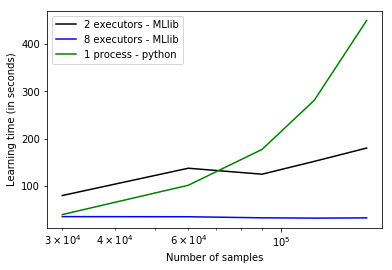

In [14]:
# Learning time
spark_2instances = [80.47699809074402,138.03380799293518,125.44569706916809,152.55336689949036,180.56784915924072]
spark_8instances = [36.01354718208313,35.721843957901,33.485682010650635,32.8361132144928,33.3182909488678]
python_1 = [40.32,102.14,177.73,281.43,449.68]

plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Learning time (in seconds)')
plt.plot(sample_size, spark_2instances, 'k')
plt.plot(sample_size, spark_8instances, 'b')
plt.plot(sample_size, python_1, 'g')
plt.legend(['2 executors - MLlib', '8 executors - MLlib', '1 process - python'])
plt.savefig('learn')
plt.show()

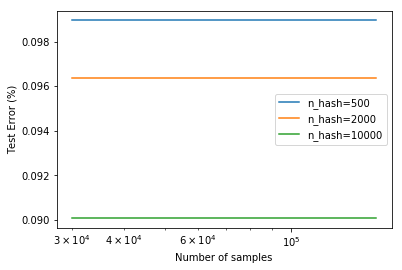

In [15]:
# SPARK: Learning time & Error for different n_hash
n_hash_500_time = [33.78788423538208,32.53039312362671,32.265034198760986,33.29247713088989,33.36445713043213]
n_hash_500_errors = [[0.09895525330179378,0.010447466982061893,0.0559826532623694,0.00275970825941263,0.05006899270648535,0.008476246796767173],
                    [0.09895525330179378,0.010447466982061893,0.0559826532623694,0.00275970825941263,0.05006899270648535,0.008476246796767173],
                    [0.09895525330179378,0.010447466982061893,0.0559826532623694,0.00275970825941263,0.05006899270648535,0.008476246796767173],
                    [0.09895525330179378,0.010447466982061893,0.0559826532623694,0.00275970825941263,0.05006899270648535,0.008476246796767173],
                    [0.09895525330179378,0.010447466982061893,0.0559826532623694,0.00275970825941263,0.05006899270648535,0.008476246796767173]]
toxic_500 = [0.09895525330179378, 0.09895525330179378, 0.09895525330179378, 0.09895525330179378, 0.09895525330179378]

n_hash_2000_time = [32.05272197723389,31.81455683708191,35.010658979415894,35.98698282241821,35.89908194541931]
n_hash_2000_errors = [[0.09639266706091065,0.010250344963532387,0.05479992115119259,0.00275970825941263,0.04967474866942634,0.008476246796767173],
                      [0.09639266706091065,0.010250344963532387,0.05479992115119259,0.00275970825941263,0.04967474866942634,0.008476246796767173],
                      [0.09639266706091065,0.010250344963532387,0.05479992115119259,0.00275970825941263,0.04967474866942634,0.008476246796767173],
                      [0.09639266706091065,0.010250344963532387,0.05479992115119259,0.00275970825941263,0.04967474866942634,0.008476246796767173],
                      [0.09639266706091065,0.010250344963532387,0.05479992115119259,0.00275970825941263,0.04967474866942634,0.008476246796767173]]
toxic_2000 = [0.09639266706091065, 0.0963926670609106, 0.0963926670609106, 0.0963926670609106, 0.0963926670609106]

n_hash_10000_time = [33.46143198013306,33.44811487197876,34.69556665420532,36.13101410865784,35.48853898048401]
n_hash_10000_errors = [[0.0900847624679677,0.010250344963532387,  0.05243445692883897,0.0031539522964715294,0.04691504041001382,0.008476246796767173],
                      [0.0900847624679677,0.010250344963532387,0.05243445692883897,0.0031539522964715294,0.04691504041001382,0.008476246796767173],
                      [0.0900847624679677,0.010250344963532387,0.05243445692883897,0.0031539522964715294,0.04691504041001382,0.008476246796767173],
                      [0.0900847624679677,0.010250344963532387,0.05243445692883897,0.0031539522964715294,0.04691504041001382,0.008476246796767173],
                      [0.0900847624679677,0.010250344963532387,0.05243445692883897,0.0031539522964715294,0.04691504041001382,0.008476246796767173]]
toxic_10000 = [0.0900847624679677, 0.0900847624679677, 0.0900847624679677, 0.0900847624679677, 0.0900847624679677]

#plt.xscale('log')
#plt.plot(sample_size, n_hash_500_time, 'k')
#plt.plot(sample_size, n_hash_2000_time, 'g')
#plt.plot(sample_size, n_hash_10000_time, 'b')

plt.xscale('log')

plt.xlabel('Number of samples')
#plt.ylabel('Learning time')
plt.ylabel('Test Error (%)')

plt.plot(sample_size, toxic_500)
plt.plot(sample_size, toxic_2000)
plt.plot(sample_size, toxic_10000)

#plt.plot(sample_size, n_hash_500_time)
#plt.plot(sample_size, n_hash_2000_time)
#plt.plot(sample_size, n_hash_10000_time)

plt.legend(['n_hash=500', 'n_hash=2000', 'n_hash=10000'])
#plt.savefig('spark_time_hash')
plt.savefig('spark_error_hash')
plt.show()

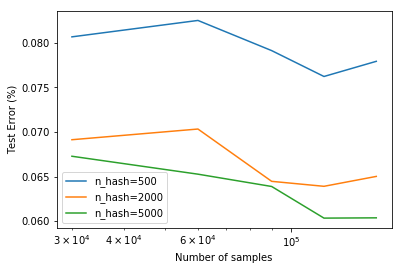

In [16]:
# Python: Learning time & Error for different n_hash
n_hash_500_time = [11.27,17.08, 21.49, 29.75,46.42]
n_hash_500_errors = [[0.08067542213883683, 0.00964888769766814, 0.040203698740284066, 0.0028142589118198558, 0.04087376038595547, 0.008844813722862499], 
                     [0.08251633986928109, 0.0099400871459695, 0.041122004357298514, 0.0038807189542483522, 0.042211328976034856, 0.007965686274509776],
                     [0.07913142857142852, 0.01001142857142856, 0.03958857142857142, 0.002422857142857171, 0.04251428571428573, 0.007908571428571376],
                     [0.07622841053462903, 0.009820416852659442, 0.03777083404869008, 0.002300587164783874, 0.04072382652886031, 0.007485492566013163], 
                     [0.07792949483412082, 0.010669227973625461, 0.03953584964435908, 0.0028814703286433874, 0.040496339753906874, 0.007813716837132056]]
toxic_500 = [0.08067542213883683,0.08251633986928109, 0.07913142857142852, 0.07622841053462903, 0.07792949483412082]

n_hash_2000_time = [25.15, 69.09 ,125.35 ,188.05 ,260.81 ]
n_hash_2000_errors = [[0.06913248150638873, 0.009818426361802302, 0.03712172158708815, 0.0036314727639542577, 0.04303967720242097, 0.008473436449226601], 
                      [0.0703323928153603, 0.010666850182368681, 0.03530383318422681, 0.003234464248847324, 0.03998348358681436, 0.00929048241690178], 
                      [0.06446258126988513, 0.010052104947664509, 0.030894084013464274, 0.003135518974500817, 0.03684234795038499, 0.00806935030202427], 
                      [0.06390507910074938, 0.010720233139050794, 0.03125867332778243, 0.0027754648903691725, 0.03663613655287257, 0.008569247849014694], 
                      [0.06501571921867755, 0.009122300675153294, 0.03136112972220795, 0.00278307478225015, 0.03556151110652994, 0.008194609081069948]]
toxic_2000 = [0.06913248150638873, 0.0703323928153603, 0.06446258126988513, 0.06390507910074938, 0.06501571921867755]

n_hash_5000_time = [70.82,186.64 ,352.26,534.49,1085.64]
n_hash_5000_acc = [[0.93272171253822633, 0.99068668334723375, 0.96580483736447043, 0.99735891020294687, 0.96038365304420348, 0.99054767862107307],
[0.93473306167553005, 0.99067615166793288, 0.96892050555977627, 0.99599419849437121, 0.962635541128531, 0.99088334829753433],
[0.93611479230452865, 0.9903578120001828, 0.96837727916647631, 0.99638989169675085, 0.96394461454096791, 0.99127176346935975],
[0.93966407379362571, 0.99105114614166723, 0.97070971294830311, 0.99679906381221173, 0.96392923521718177, 0.99101672747298131],
[0.93963301809210531, 0.98984888980263153, 0.96923828125, 0.99704461348684215, 0.96466385690789469, 0.99141652960526316]]
toxic_5000 = [1-0.93272171253822633, 1-0.93473306167553005, 1-0.93611479230452865, 1-0.93966407379362571, 1-0.93963301809210531]

plt.xscale('log')

plt.xlabel('Number of samples')
#plt.ylabel('Learning time')
plt.ylabel('Test Error (%)')

#plt.plot(sample_size, n_hash_500_time)
#plt.plot(sample_size, n_hash_2000_time)
#plt.plot(sample_size, n_hash_5000_time)

plt.plot(sample_size, toxic_500)
plt.plot(sample_size, toxic_2000)
plt.plot(sample_size, toxic_5000)

plt.legend(['n_hash=500', 'n_hash=2000', 'n_hash=5000'])
#plt.savefig('python_time_hash')
plt.savefig('python_error_hash')
plt.show()